In [1]:
import pickle
import numpy as np
import torch
import pandas as pd
from torch import nn

In [2]:
TRAIN = True

In [3]:
a = pd.read_csv('../processed_data/fluorescence_dataset.csv')
a = pd.read_excel('../raw_data/41592_2018_45_MOESM4_ESM.xlsx', skiprows=6, engine='openpyxl')
a.rename(columns={'Standard Name':'gene', 'Systematic Name':"systematicName"}, inplace=True)

b = pd.read_csv('../processed_data/yamanishi_data.csv', header = 0)

/home/vaslem/code/intbioproj/.venv/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
def transform(x):
    x = x.copy()
    x[x<=0] = 0.01 
    return np.log10(x)
def normalize(x):
    return (x - x.min())/(x.max() - x.min())
c = a.merge(b, on='gene')
c.intensity_x = normalize(transform(c.intensity_x))
c['intensity.1'] = normalize(transform(c['intensity.1']))
c['intensity.2'] = normalize(transform(c['intensity.2']))
c['intensity_y'] = normalize(transform(c['intensity_y']))
c['fold_bkg'] = transform(c['fold_bkg'])
c['fold_bkg.1'] = transform(c['fold_bkg.1'])
c['fold_bkg.2'] = transform(c['fold_bkg.2'])

c['diff1'] =  c.intensity_x - c['intensity.1']
c['diff2'] =  c.intensity_x - c['intensity.2']
c['diff3'] =  c.fold_bkg - c['fold_bkg.1']
c['diff4'] =  c.fold_bkg - c['fold_bkg.2']
c['div1'] =  c.intensity_x / c['intensity.1']
c['div2'] =  c.intensity_x / c['intensity.2']
c['div3'] =  c.fold_bkg / c['fold_bkg.1']
c['div4'] =  c.fold_bkg / c['fold_bkg.2']

c.corr()['intensity_y'].sort_values()

div2           0.035089
div4           0.044465
diff1          0.071672
intensity.2    0.073393
div1           0.081652
diff2          0.103972
fold_bkg.2     0.135199
intensity.1    0.148385
fold_bkg.1     0.156987
div3           0.170411
intensity_x    0.177065
diff4          0.195595
fold_bkg       0.223439
diff3          0.360136
intensity_y    1.000000
Name: intensity_y, dtype: float64

In [5]:
c['diff3'].describe()

count    3992.000000
mean       -0.064435
std         0.099830
min        -0.989659
25%        -0.098950
50%        -0.041393
75%        -0.007825
max         0.672838
Name: diff3, dtype: float64

In [6]:
to_use = transform(a.fold_bkg) - transform(a['fold_bkg.1'])
to_use.index = a.gene
to_use.name = 'intensity'

<AxesSubplot:>

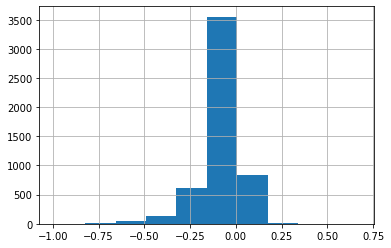

In [7]:
to_use.hist()

In [8]:
to_use.min(), to_use.max()

(-0.9896591666617807, 0.6728378625060083)

In [9]:
to_use.describe()

count    5214.000000
mean       -0.072626
std         0.114017
min        -0.989659
25%        -0.105891
50%        -0.043275
75%        -0.007969
max         0.672838
Name: intensity, dtype: float64

In [10]:
to_use

gene
SSA1    -0.220307
ERP2    -0.088624
FUN14   -0.075380
SPO7     0.018483
MDM10         NaN
           ...   
NaN     -0.041393
SGE1    -0.037789
ARR1    -0.020685
ARR2    -0.082670
ARR3    -0.030669
Name: intensity, Length: 5254, dtype: float64

In [11]:
FIL = 'utrs_embeddings_6_10_50'
Y_ID = ''
fDf = ((to_use - to_use.min())/(to_use.max() - to_use.min())).reset_index()
seqs = pd.read_csv('../processed_data/utrs.csv')
seqs = seqs[['Gene Name', 'foreign']].dropna(axis=0).rename(columns={'Gene Name': 'gene', 'foreign':'utr_seq'})
fDf = seqs.merge(fDf, on='gene', how='left')
with open(f'../processed_data/{FIL}{Y_ID}.pkl', 'rb') as inp:
    [genes, tokenized, embedding_keys, embedding_mat] = pickle.load(inp)
fDf = fDf.set_index('gene').loc[genes,:]
checkpoint_path = f"../model/utrs_lstm_weights{Y_ID}.ckpt"
# tokenized = [s for s,g in zip(tokenized, seq_geneset_mask) if g]
# fDf = fDf.set_index('gene').loc[seq_geneset, :].reset_index()
# mask = fDf['intensity'] > 0 # negative intensities make no sense
# print(f"Removing {sum(~mask)} rows that have negative intensity")
# fDf = fDf[mask]
# tokenized = [x for m,x in zip(mask, tokenized) if m]
len(fDf), len(tokenized)

(4869, 4869)

In [12]:
fDf

,utr_seq,intensity
gene,,
VPS8,ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAAT...,NaN
SSA1,AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...,0.462769
ERP2,AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...,0.541977
FUN14,AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...,0.549943
SPO7,AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...,0.606403
...,...,...
TKL1,AATTCTGATCGTAGATCATCAGATTTGATATGATATTATTTGTGAA...,0.600743
MRL1,AACAATGCATACTTTGTACGTTCAAAATACAATGCAGTAGATATAT...,0.580723
GRS2,ACTGAAAAAAGAGGGGAATTTTTAGATACTGAAATGATATTTTAGA...,0.540807


In [13]:
mask = ~fDf['intensity'].isnull()
fDf = fDf[mask]
tokenized = [x for m,x in zip(mask, tokenized) if m]
# fDf['logInt'] = np.log(fDf['intensity'])
# maskLog = fDf['logInt']>-20
# print(f"Removing {sum(~maskLog)} rows that have outliers log Intensity values <= -20")
# fDf = fDf[fDf['logInt']>-20]
# tokenized = [x for m,x in zip(maskLog, tokenized) if m]
# y = fDf['logInt'].copy()

y = fDf['intensity'].copy()
len(fDf), len(tokenized)

(3734, 3734)

In [14]:
y_dig = np.digitize(y, np.quantile(y, np.arange(0,1,0.1)))
mask0 = y_dig == 1
mask1 = y_dig == 10

mask = mask0 | mask1
x = [t for (t,m) in zip(tokenized,mask) if m]
y_bin = y_dig[mask] == 10
len(x), y_bin.shape[0]
y_bin = y > np.median(y)

In [15]:
from tensorflow.keras.utils import to_categorical
from tensorflow.ragged import constant
import os
import tensorflow as tf

In [16]:
from tensorflow.keras.optimizers import Adam

In [17]:
# Tensorflow 1.9; Keras 2.2.0 (latest versions)
# should be backwards compatible upto Keras 2.0.9 and tf 1.5
from keras.models import Model
from keras.layers import *
import numpy as np
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
def create_models():
    #Get a sequence of indexes of words as input:
    # Keras supports dynamic input lengths if you provide (None,) as the 
    #  input shape
    inp = Input((None,))
    #Embed words into vectors of size 10 each:
    # Output shape is (None,10)
    
    embs = Embedding(embedding_mat.shape[0],
                            embedding_mat.shape[1],
                            weights=[embedding_mat],
                            trainable=False)(inp)
    D_SIZE = 0.3
    dropout = SpatialDropout1D(D_SIZE)(embs)
    # Run LSTM on these vectors and return output on each timestep
    # Output shape is (None,5)
    lstm = Bidirectional(LSTM(12, return_sequences=True,unit_forget_bias=True))(dropout)
    dropout = SpatialDropout1D(D_SIZE)(lstm)
    lstm = Bidirectional(LSTM(8, return_sequences=True,unit_forget_bias=True))(dropout)
    dropout = SpatialDropout1D(D_SIZE)(lstm)
    lstm = Bidirectional(LSTM(4, return_sequences=True,unit_forget_bias=True))(dropout)
    ##Attention Block
    #Transform each timestep into 1 value (attention_value) 
    # Output shape is (None,1)
    attention = TimeDistributed(Dense(1))(lstm)
    #By running softmax on axis 1 we force attention_values
    # to sum up to 1. We are effectively assigning a "weight" to each timestep
    # Output shape is still (None,1) but each value changes
    attention_vals = Softmax(axis=1, dtype='float32')(attention)
    # Multiply the encoded timestep by the respective weight
    # I.e. we are scaling each timestep based on its weight
    # Output shape is (None,5): (None,5)*(None,1)=(None,5)
    scaled_vecs = Multiply()([lstm,attention_vals])
    # Sum up all scaled timesteps into 1 vector 
    # i.e. obtain a weighted sum of timesteps
    # Output shape is (5,) : Observe the time dimension got collapsed
    context_vector = Lambda(lambda x: tf.keras.backend.sum(x,axis=1))(scaled_vecs)
    ##Attention Block over
    # Get the output out
    x = Dense(1)(context_vector)
    out = Activation('relu', dtype='float32', name='predictions')(x)
    model = Model(inp, out)
    model_with_attention_output = Model(inp, [out, attention_vals])
    model.compile(optimizer=Adam(learning_rate=1e-3),loss='mean_squared_error', metrics=['mean_squared_error'])
#     out = Activation('sigmoid', dtype='float32', name='predictions')(x)
#     model = Model(inp, out)
#     model_with_attention_output = Model(inp, [out, attention_vals])
#     model.compile(optimizer=Adam(learning_rate=1e-3),loss='binary_crossentropy', metrics=['accuracy'])
    return model, model_with_attention_output

model,model_with_attention_output = create_models()
model.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070, compute capability 7.5


2021-12-20 19:10:09.753087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 19:10:09.758344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 19:10:09.758721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 19:10:09.759383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 19:10:09.769338: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized wit

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 50)     251350      ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, None, 50)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 24)     6048        ['spatial_dropout1d[0][0]']  

In [18]:
from keras.preprocessing.sequence import pad_sequences

In [19]:
if TRAIN:
    seq_len = max([len(y) for y in x])
    print(seq_len)

1546


In [25]:
if TRAIN:
    model,model_with_attention_output = create_models()
    padded = pad_sequences(x,seq_len,value=-1)

    # Create a callback that saves the model's weights
    
    ts_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + '_train',
                                                     save_weights_only=True,save_best_only=True,
#                                                      monitor='accuracy',
                                                     monitor='mean_squared_error',
                                                     verbose=1)
    vs_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + '_val',
                                                     save_weights_only=True,save_best_only=True,
#                                                      monitor='val_accuracy',
                                                     monitor='val_mean_squared_error',
                                                     verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=100, verbose=0,
        mode='auto', baseline=None, restore_best_weights=False
    )
    history = model.fit(
        padded,
#         np.array(y_bin),
        np.array(y),
        batch_size=32, epochs=1000,
        callbacks=[vs_callback, ts_callback
                   , es_callback
                  ],
        validation_split=0.1)


Epoch 1/1000
22/22 [==============================] - ETA: 0s - loss: 0.2067 - mean_squared_error: 0.2067
Epoch 00001: val_mean_squared_error improved from inf to 0.04729, saving model to ../model/utrs_lstm_weights.ckpt_val

Epoch 00001: mean_squared_error improved from inf to 0.20673, saving model to ../model/utrs_lstm_weights.ckpt_train
22/22 [==============================] - 11s 253ms/step - loss: 0.2067 - mean_squared_error: 0.2067 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 2/1000
22/22 [==============================] - ETA: 0s - loss: 0.0209 - mean_squared_error: 0.0209
Epoch 00002: val_mean_squared_error improved from 0.04729 to 0.01343, saving model to ../model/utrs_lstm_weights.ckpt_val

Epoch 00002: mean_squared_error improved from 0.20673 to 0.02089, saving model to ../model/utrs_lstm_weights.ckpt_train
22/22 [==============================] - 4s 189ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 3

22/22 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 00020: val_mean_squared_error did not improve from 0.00476

Epoch 00020: mean_squared_error did not improve from 0.00385
22/22 [==============================] - 4s 187ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 21/1000
22/22 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 00021: val_mean_squared_error did not improve from 0.00476

Epoch 00021: mean_squared_error improved from 0.00385 to 0.00380, saving model to ../model/utrs_lstm_weights.ckpt_train
22/22 [==============================] - 4s 182ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 22/1000
22/22 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 00022: val_mean_squared_error did not improve from 0.00476

Epoch 00022:

22/22 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 00041: val_mean_squared_error did not improve from 0.00472

Epoch 00041: mean_squared_error did not improve from 0.00380
22/22 [==============================] - 4s 184ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 42/1000
22/22 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 00042: val_mean_squared_error did not improve from 0.00472

Epoch 00042: mean_squared_error did not improve from 0.00380
22/22 [==============================] - 4s 191ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 43/1000
22/22 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 00043: val_mean_squared_error did not improve from 0.00472

Epoch 00043: mean_squared_error did not improve from 0.00380
22/22 [===

Epoch 62/1000
22/22 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 00062: val_mean_squared_error did not improve from 0.00472

Epoch 00062: mean_squared_error did not improve from 0.00361
22/22 [==============================] - 4s 185ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 63/1000
22/22 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 00063: val_mean_squared_error did not improve from 0.00472

Epoch 00063: mean_squared_error did not improve from 0.00361
22/22 [==============================] - 4s 183ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 64/1000
22/22 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 00064: val_mean_squared_error did not improve from 0.00472

Epoch 00064: mean_squared_error did not improve from 0.00

Epoch 83/1000
22/22 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 00083: val_mean_squared_error did not improve from 0.00466

Epoch 00083: mean_squared_error did not improve from 0.00354
22/22 [==============================] - 4s 190ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 84/1000
22/22 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 00084: val_mean_squared_error did not improve from 0.00466

Epoch 00084: mean_squared_error did not improve from 0.00354
22/22 [==============================] - 4s 184ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 85/1000
22/22 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 00085: val_mean_squared_error did not improve from 0.00466

Epoch 00085: mean_squared_error did not improve from 0.00

Epoch 104/1000
22/22 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 00104: val_mean_squared_error did not improve from 0.00466

Epoch 00104: mean_squared_error did not improve from 0.00352
22/22 [==============================] - 4s 188ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 105/1000
22/22 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 00105: val_mean_squared_error did not improve from 0.00466

Epoch 00105: mean_squared_error improved from 0.00352 to 0.00341, saving model to ../model/utrs_lstm_weights.ckpt_train
22/22 [==============================] - 4s 188ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 106/1000
22/22 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 00106: val_mean_squared_error did not improve from 0.00

22/22 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 00125: val_mean_squared_error did not improve from 0.00466

Epoch 00125: mean_squared_error did not improve from 0.00341
22/22 [==============================] - 4s 191ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 126/1000
22/22 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 00126: val_mean_squared_error did not improve from 0.00466

Epoch 00126: mean_squared_error did not improve from 0.00341
22/22 [==============================] - 4s 189ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 127/1000
22/22 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 00127: val_mean_squared_error did not improve from 0.00466

Epoch 00127: mean_squared_error did not improve from 0.00341
22/22 [=

Epoch 146/1000
22/22 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 00146: val_mean_squared_error did not improve from 0.00463

Epoch 00146: mean_squared_error did not improve from 0.00339
22/22 [==============================] - 4s 193ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 147/1000
22/22 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 00147: val_mean_squared_error did not improve from 0.00463

Epoch 00147: mean_squared_error did not improve from 0.00339
22/22 [==============================] - 4s 191ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 148/1000
22/22 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 00148: val_mean_squared_error did not improve from 0.00463

Epoch 00148: mean_squared_error did not improve from 0

Epoch 167/1000
22/22 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 00167: val_mean_squared_error did not improve from 0.00461

Epoch 00167: mean_squared_error did not improve from 0.00334
22/22 [==============================] - 4s 180ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 168/1000
22/22 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 00168: val_mean_squared_error did not improve from 0.00461

Epoch 00168: mean_squared_error did not improve from 0.00334
22/22 [==============================] - 4s 180ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 169/1000
22/22 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 00169: val_mean_squared_error did not improve from 0.00461

Epoch 00169: mean_squared_error did not improve from 0

22/22 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 00188: val_mean_squared_error did not improve from 0.00457

Epoch 00188: mean_squared_error did not improve from 0.00334
22/22 [==============================] - 4s 180ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 189/1000
22/22 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 00189: val_mean_squared_error did not improve from 0.00457

Epoch 00189: mean_squared_error did not improve from 0.00334
22/22 [==============================] - 4s 179ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 190/1000
22/22 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 00190: val_mean_squared_error did not improve from 0.00457

Epoch 00190: mean_squared_error did not improve from 0.00334
22/22 [=

Epoch 209/1000
22/22 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 00209: val_mean_squared_error did not improve from 0.00457

Epoch 00209: mean_squared_error did not improve from 0.00328
22/22 [==============================] - 4s 184ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 210/1000
22/22 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 00210: val_mean_squared_error did not improve from 0.00457

Epoch 00210: mean_squared_error did not improve from 0.00328
22/22 [==============================] - 4s 185ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 211/1000
22/22 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 00211: val_mean_squared_error did not improve from 0.00457

Epoch 00211: mean_squared_error did not improve from 0

Epoch 230/1000
22/22 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 00230: val_mean_squared_error did not improve from 0.00457

Epoch 00230: mean_squared_error did not improve from 0.00312
22/22 [==============================] - 4s 179ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 231/1000
22/22 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 00231: val_mean_squared_error did not improve from 0.00457

Epoch 00231: mean_squared_error did not improve from 0.00312
22/22 [==============================] - 4s 181ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 232/1000
22/22 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 00232: val_mean_squared_error did not improve from 0.00457

Epoch 00232: mean_squared_error did not improve from 0

Epoch 251/1000
22/22 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 00251: val_mean_squared_error did not improve from 0.00444

Epoch 00251: mean_squared_error did not improve from 0.00299
22/22 [==============================] - 4s 184ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 252/1000
22/22 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 00252: val_mean_squared_error did not improve from 0.00444

Epoch 00252: mean_squared_error did not improve from 0.00299
22/22 [==============================] - 4s 184ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 253/1000
22/22 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 00253: val_mean_squared_error did not improve from 0.00444

Epoch 00253: mean_squared_error did not improve from 0

22/22 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 00272: val_mean_squared_error did not improve from 0.00444

Epoch 00272: mean_squared_error did not improve from 0.00296
22/22 [==============================] - 4s 180ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 273/1000
22/22 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 00273: val_mean_squared_error did not improve from 0.00444

Epoch 00273: mean_squared_error did not improve from 0.00296
22/22 [==============================] - 4s 184ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 274/1000
22/22 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 00274: val_mean_squared_error did not improve from 0.00444

Epoch 00274: mean_squared_error did not improve from 0.00296
22/22 [=

Epoch 293/1000
22/22 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 00293: val_mean_squared_error did not improve from 0.00444

Epoch 00293: mean_squared_error did not improve from 0.00286
22/22 [==============================] - 4s 183ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 294/1000
22/22 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 00294: val_mean_squared_error did not improve from 0.00444

Epoch 00294: mean_squared_error did not improve from 0.00286
22/22 [==============================] - 4s 185ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 295/1000
22/22 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 00295: val_mean_squared_error did not improve from 0.00444

Epoch 00295: mean_squared_error did not improve from 0

Epoch 314/1000
22/22 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 00314: val_mean_squared_error did not improve from 0.00444

Epoch 00314: mean_squared_error did not improve from 0.00283
22/22 [==============================] - 4s 178ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 315/1000
22/22 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 00315: val_mean_squared_error did not improve from 0.00444

Epoch 00315: mean_squared_error did not improve from 0.00283
22/22 [==============================] - 4s 184ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 316/1000
22/22 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 00316: val_mean_squared_error did not improve from 0.00444

Epoch 00316: mean_squared_error improved from 0.00283 

Epoch 335/1000
22/22 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 00335: val_mean_squared_error did not improve from 0.00444

Epoch 00335: mean_squared_error did not improve from 0.00274
22/22 [==============================] - 4s 183ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 336/1000
22/22 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 00336: val_mean_squared_error did not improve from 0.00444

Epoch 00336: mean_squared_error did not improve from 0.00274
22/22 [==============================] - 4s 180ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 337/1000
22/22 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 00337: val_mean_squared_error did not improve from 0.00444

Epoch 00337: mean_squared_error did not improve from 0

In [26]:
if TRAIN:
    with open(f'../model/training_history{Y_ID}.pkl', 'wb') as out:
        pickle.dump(history.history, out)

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


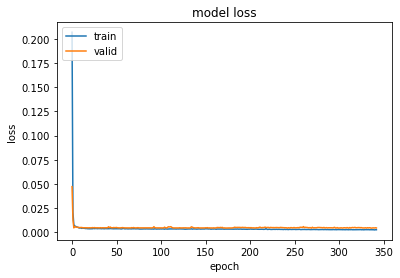

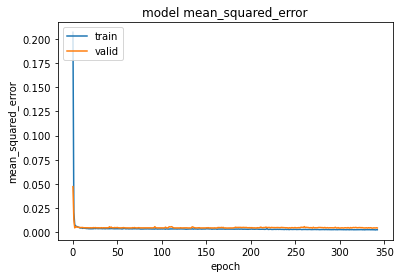

In [28]:
with open(f'../model/training_history{Y_ID}.pkl', 'rb') as inp:
    history= pickle.load(inp)
import matplotlib.pyplot as plt
# list all data in history
print(history.keys())
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for accuracy
# plt.plot(history['accuracy'])
# plt.plot(history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
plt.plot(history['mean_squared_error'])
plt.plot(history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [29]:
model_with_attention_output.load_weights(checkpoint_path + '_val')

In [30]:
fi_preds, words_importances_per_seq = model_with_attention_output.predict(constant([np.array(t) for t in tokenized],dtype='int16'),batch_size=128)

In [55]:
y.index[np.argmin(np.abs(np.array(fi_preds).flatten() - y))]

'DBR1'

In [31]:
words_importances_per_seq = words_importances_per_seq.numpy()

In [32]:
np.min([np.min(p) for p in words_importances_per_seq])

0.00033217182

In [33]:
np.max([np.max(p) for p in words_importances_per_seq])

1.0

In [34]:
def reconstruct_sequence(ori_seq, sub_seqs, importances):
    unseen = ori_seq
    reconstructed_importances = np.zeros(len(ori_seq))
    t1 = 0
    t0 = 0
    den_vec = np.zeros(len(ori_seq))
    nom_vec = np.zeros(len(ori_seq))
    for i,s,e in zip(importances[:-1], sub_seqs[:-1], sub_seqs[1:]):
        t0 += t1
        t1 = unseen.find(e)
        # max is used to handle gaps created due to rounding errors in k-mer partitioning (among hits of interest)
        nom_vec[t0:t0 + max(t1, len(s))] += i
        den_vec[t0:t0 + max(t1, len(s))] += 1
        unseen = unseen[t1:]
    nom_vec[-len(sub_seqs[-1]):] += importances[-1]
    den_vec[-len(sub_seqs[-1]):] += 1
    
    reconstructed_importances = nom_vec/den_vec
    return reconstructed_importances

In [35]:
def plotSignature(ind):
    print('Gene:', fDf.index[ind])
    p = reconstruct_sequence(fDf.iloc[ind]['utr_seq'], np.array(embedding_keys)[tokenized[ind]], words_importances_per_seq[ind])
    plt.figure(figsize=(60,5))
    plt.plot(p)
    _=plt.xticks(np.arange(len(fDf.iloc[ind]['utr_seq'])), list(fDf.iloc[ind]['utr_seq']))

Gene: SSA1


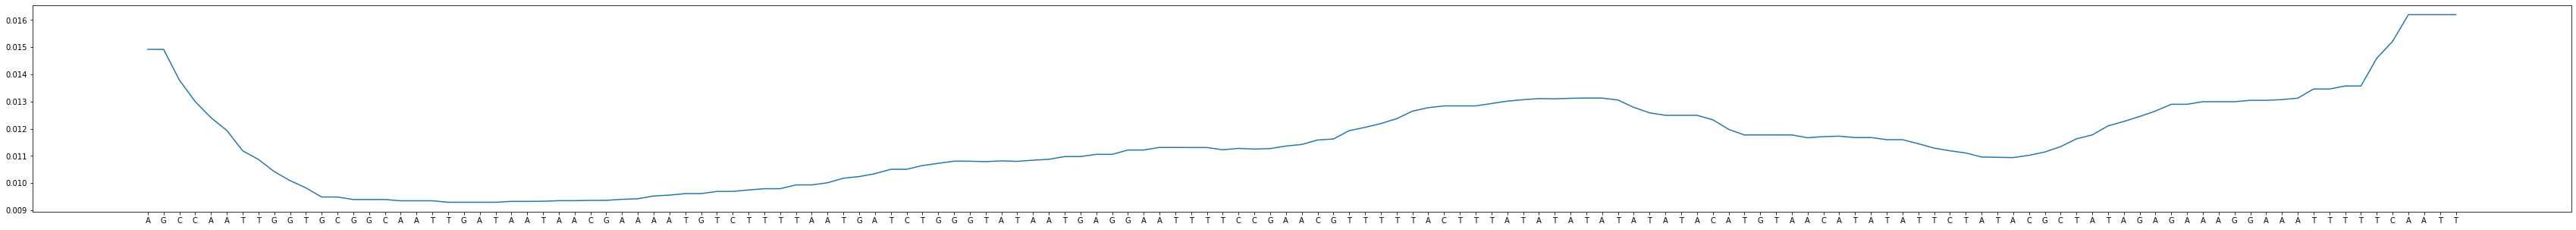

In [36]:
plotSignature(0)

Gene: ERP2


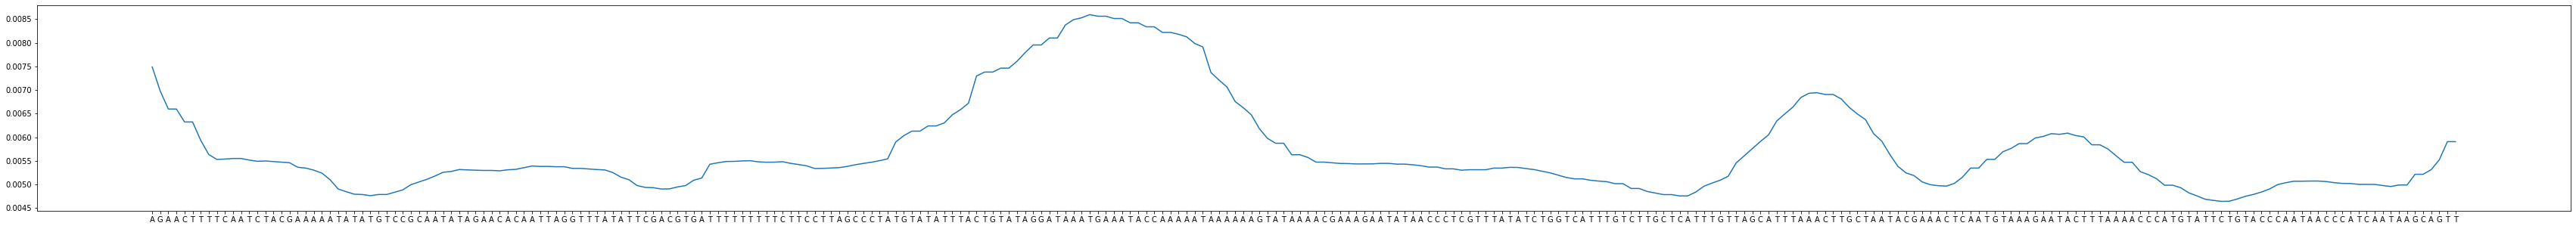

In [37]:
plotSignature(1)

Gene: FUN14


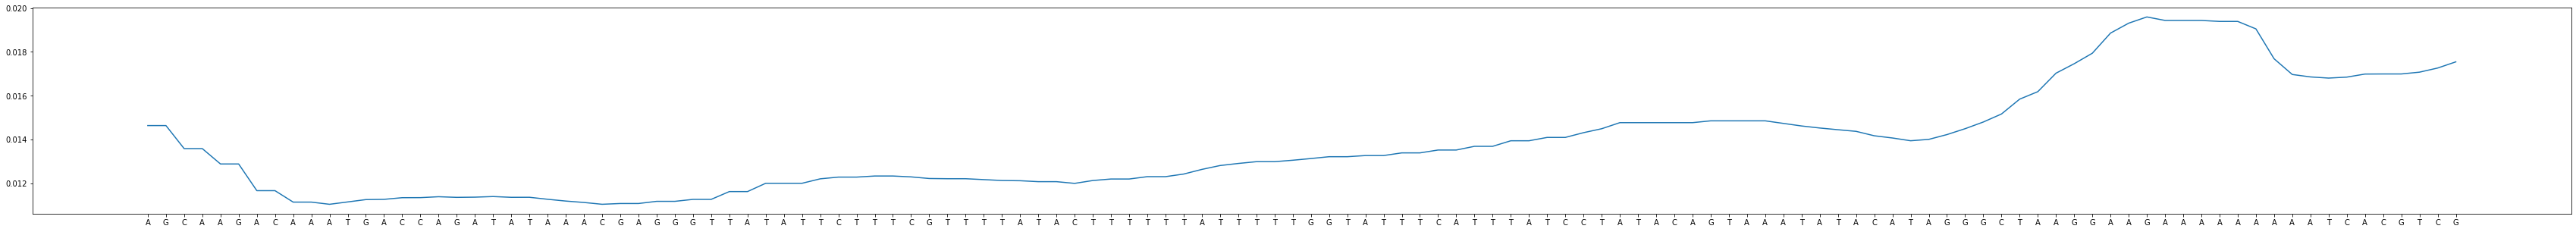

In [38]:
plotSignature(2)

Gene: SPO7


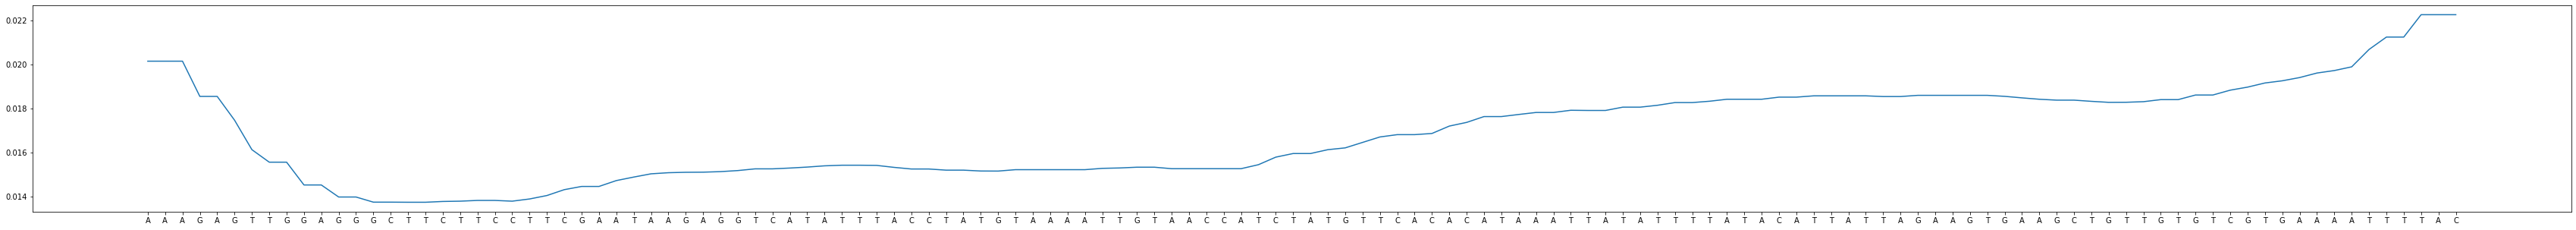

In [39]:
plotSignature(3)

Gene: SWC3


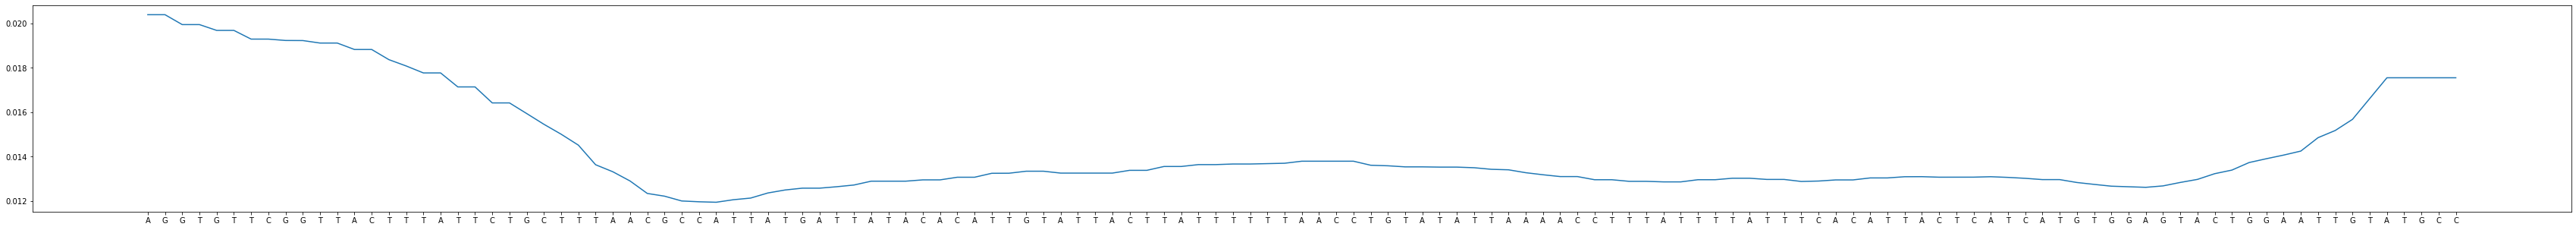

In [40]:
plotSignature(4)

Gene: CYS3


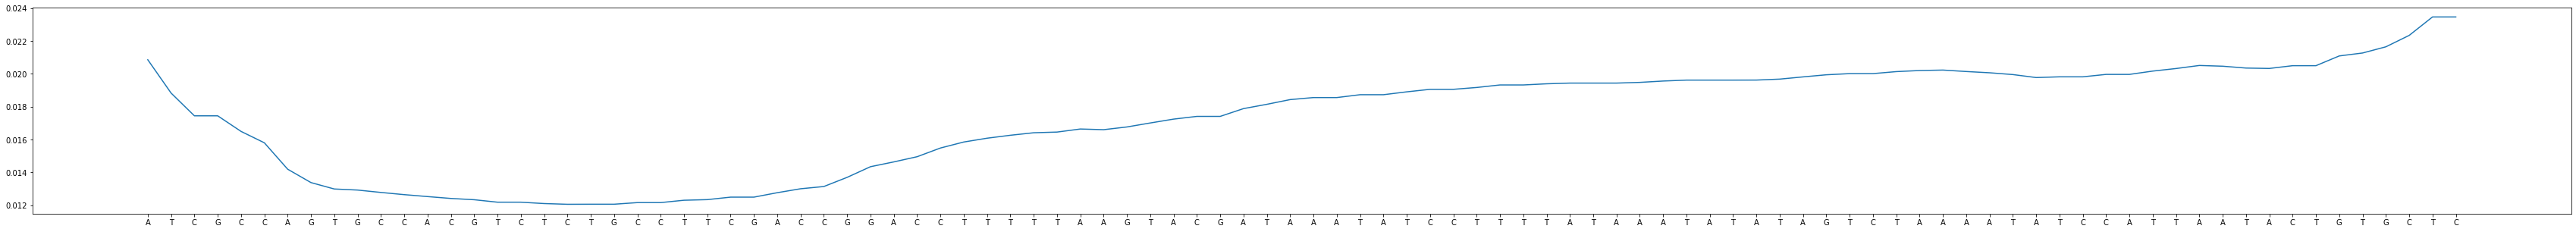

In [41]:
plotSignature(5)

Gene: DEP1


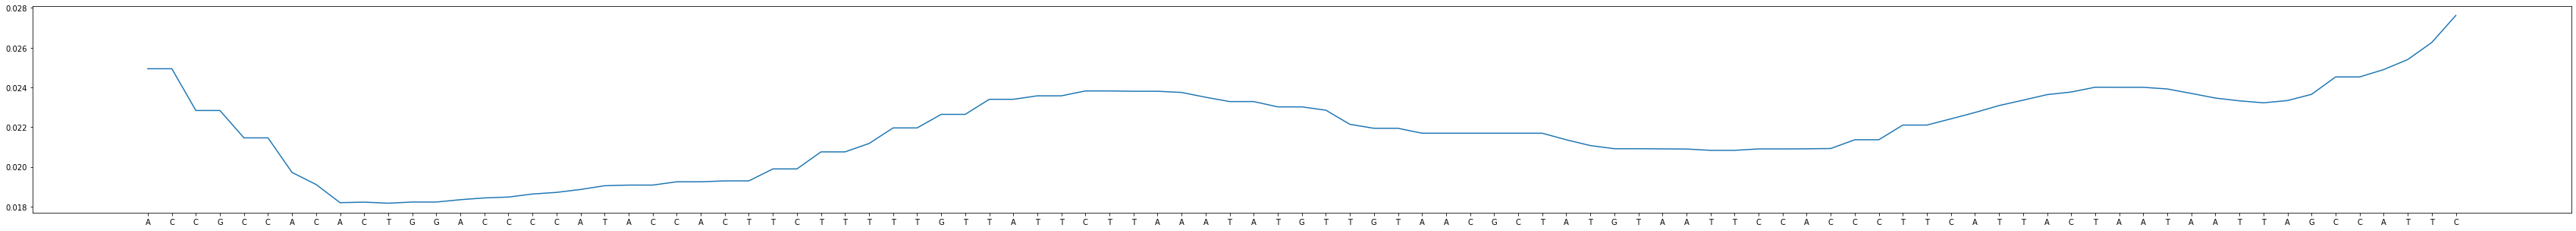

In [42]:
plotSignature(6)

Gene: NTG1


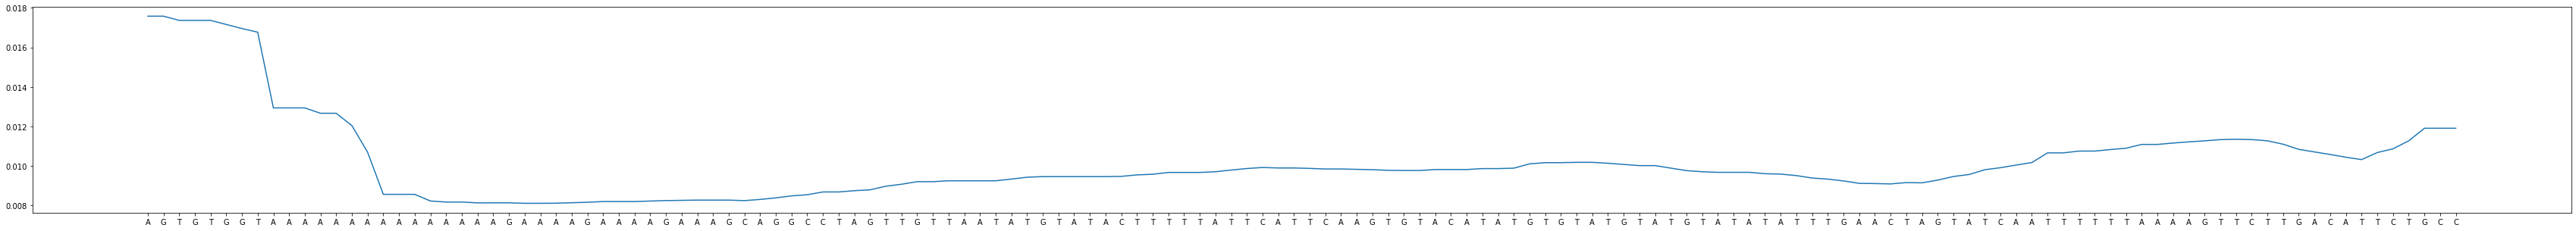

In [43]:
plotSignature(7)

Gene: TPD3


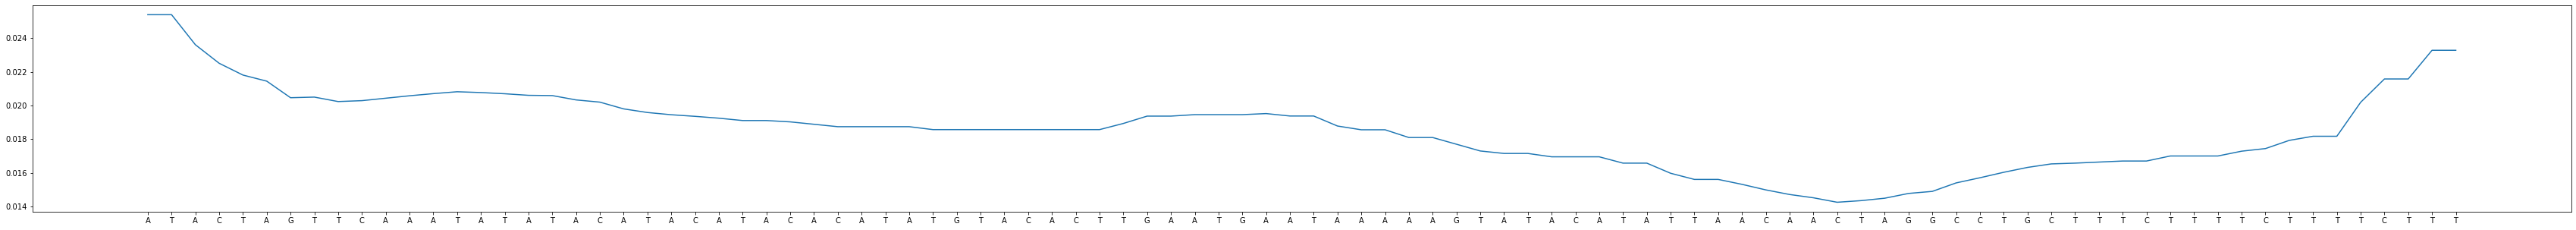

In [44]:
plotSignature(8)

Gene: DBR1


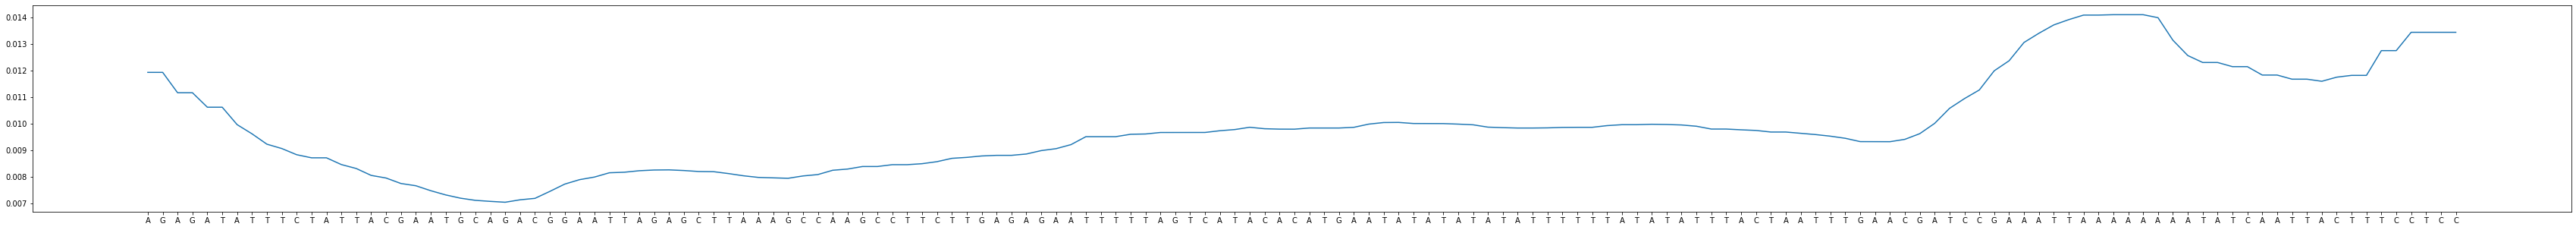

In [56]:
plotSignature(2000)

In [45]:
top10i1 = np.array([np.argsort(-np.array(x).ravel(),)[:10] for x,f in zip(words_importances_per_seq, y_bin) if f==1])
top10i0 = np.array([np.argsort(-np.array(x).ravel(),)[:10] for x,f in zip(words_importances_per_seq, y_bin) if f==0])

/tmp/ipykernel_294665/3654512027.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top10i1 = np.array([np.argsort(-np.array(x).ravel(),)[:10] for x,f in zip(words_importances_per_seq, y_bin) if f==1])
/tmp/ipykernel_294665/3654512027.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top10i0 = np.array([np.argsort(-np.array(x).ravel(),)[:10] for x,f in zip(words_importances_per_seq, y_bin) if f==0])


### Most frequent k-mers appearing in the sequences that have been labelled with 1

In [ ]:
plt.figure(figsize=(25,5))
top1i1bins = np.bincount([x[0] for x in top10i1])
top1i1inds = np.argsort(-top1i1bins)
top1i1inds = top1i1inds[top1i1bins[top1i1inds]>0]
plt.bar(np.array(embedding_keys)[top1i1inds], top1i1bins[top1i1inds],)
_=plt.xticks(rotation=70)

### Network architecture
Architecture defined by the awesome architect in https://stackoverflow.com/questions/51477977/highlighting-important-words-in-a-sentence-using-deep-learning/51481366 with the spatial dropout addition to cater for generalization

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='../figures/utrs_model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)